In [1]:
import os
import re
import numpy as np
import pandas as pd
import tqdm
import scipy
import random
from cycler import cycler
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

import torch
from torch import nn
from torch.utils.data import DataLoader

import optuna
from ray import train, tune
from ray.tune.search.optuna import OptunaSearch
from ray.tune.search.basic_variant import BasicVariantGenerator

import snntorch as snn
from snntorch import surrogate, utils, functional as SF

import utils_fn
import network
from params import *
from train_eval import *

torch.manual_seed(22)

%reload_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    'axes.labelsize': 30.0,
    'grid.alpha': 0.6,
    'legend.framealpha': 0.6,
    "text.usetex": True,
    "font.family": "serif",
    'figure.figsize': [12,6],
    "font.size": 30,
    "hatch.linewidth": 0.0,
    "hatch.color": (0,0,0,0.0),
    "axes.prop_cycle": cycler(color=sns.color_palette("tab10"))
    })

### Load train/valid/test dataset and create Data Loader

In [3]:
N_WIN = 232
N_RANGE_BINS = 10
WIN_LEN = 64
INP_SHAPE = [2, 232, 10, 64]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

train_dataset = torch.load('data/train_dataset_split_subj.pt')#, map_location=torch.device(device)
val_dataset = torch.load('data/val_dataset_split_subj.pt')#, map_location=torch.device(device))
test_dataset = torch.load('data/test_dataset_split_subj.pt')#, map_location=torch.device(device))

batch = 8
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_loader =  DataLoader(val_dataset, batch_size=batch)
test_loader = DataLoader(test_dataset, batch_size=1)

x = next(iter(train_loader))[0]

print(f"\nShape of each element in the dataloader: {x.shape}")
print(f"Number of elements in train - valid - test set: {len(train_dataset)} - {len(val_dataset)} - {len(test_dataset)}")

Using cuda device

Shape of each element in the dataloader: torch.Size([8, 2, 232, 10, 64])
Number of elements in train - valid - test set: 1680 - 138 - 182


#### SCAE model

In [9]:
class SCAE(nn.Module):
    def __init__(self, autoencoder, snn):
        super(SCAE, self).__init__()
        self.autoencoder = autoencoder
        self.snn = snn

    def forward(self, x):
        encoded, decoded = self.autoencoder(x)
        clss = self.snn(encoded)  
        n_spikes = encoded.abs().mean()

        return n_spikes, decoded, clss

### Hyperparameter optimization

### 1. # Conv. layers in the SAE

In [ ]:
autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,7),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.5, 
                           threshold = 0.8, 
                           surr_grad = surrogate.fast_sigmoid(),
                           learn_beta = True, 
                           learn_threshold = True, 
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,32], 
                     timesteps = 116,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.8,
                     threshold = 1,
                     learn_thr = False, 
                     learn_beta = False,
                     surr_grad = surrogate.fast_sigmoid()
                     )

net = SCAE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.85,
                Lambda = 0.3,
                acc_steps = 1,
                patience = 15,
                model_path = None 
)

trainer.fit(
    train_loader = train_loader,
    val_loader = val_loader,
    epochs = 50
)


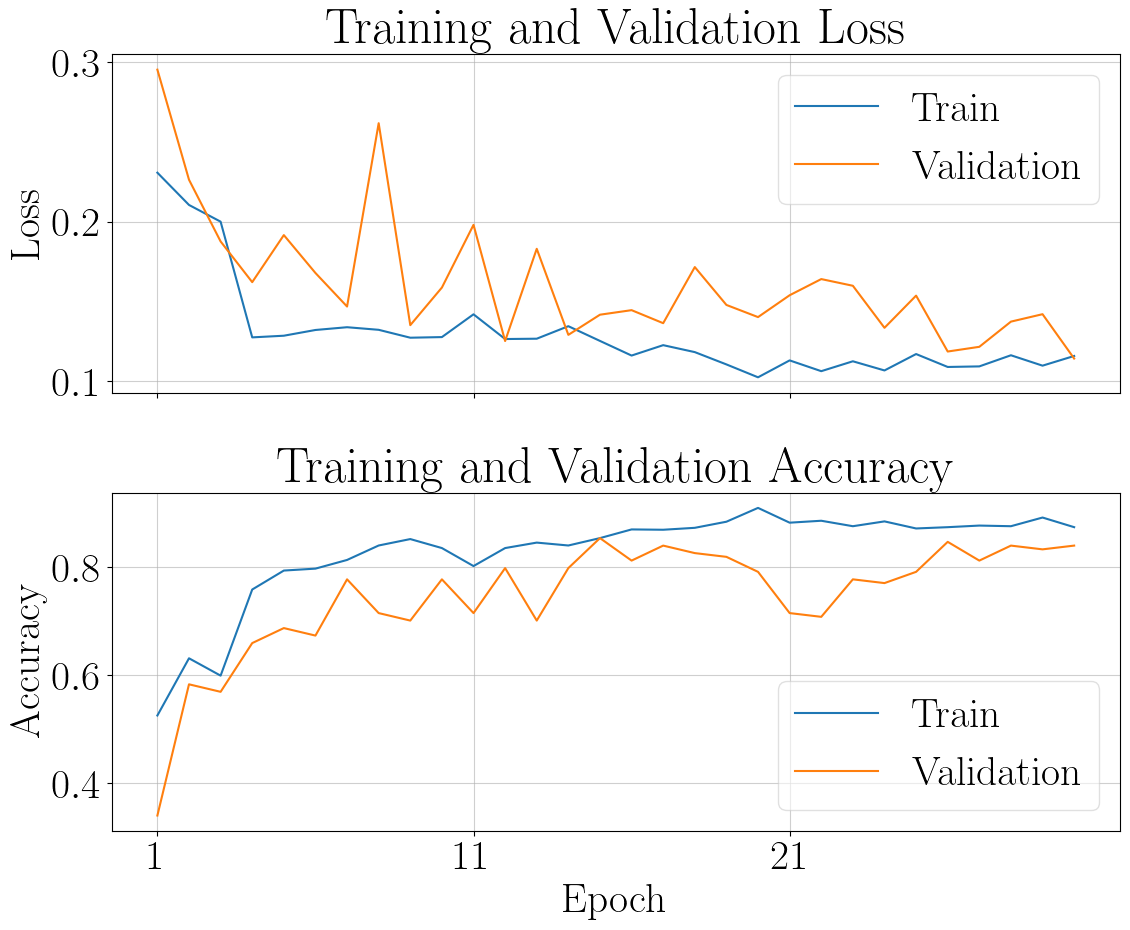

In [6]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

## Grid Search

In [ ]:
def objective(config):  
    assert torch.cuda.is_available()

    autoencoder = network.scae(
                           channels = config['feature_maps'], 
                           kernel_size = config['kernel_scae'],
                           stride = 1, 
                           timesteps = 1,
                           beta = config['beta'], 
                           threshold = 1.0, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = config['surrogate_grad'],
                           ).to(device)

    snn =  network.snn_1(input_shape = INP_SHAPE, 
                        hidden = config['hidden_neurons'], 
                        timesteps = config['timestep'],
                        kernel = (1,1,4),
                        stride = (1,2,2),
                        beta = config['beta'], 
                        threshold = 1.0,
                        learn_thr = True, 
                        learn_beta = True,
                        surr_grad = config['surrogate_grad'],
                        ).to(device)
    
    net = SCAE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

    
    trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.85,
                Lambda = 0.4,
                acc_steps = 1,
                patience = 15,
                model_path = None)

    trainer.fit(
            train_loader = train_loader,
            val_loader = val_loader,
            epochs = 50)
        
    val_acc = np.mean(trainer.val_acc_ls)
    train.report({"mean_accuracy": val_acc})  

search_space = {"feature_maps": tune.grid_search([64, 128]),
                "kernel_scae": tune.grid_search([(1,1,3), (1,1,5)]),
                "beta": tune.grid_search([0.9, 0.5]),
                "surrogate_grad": tune.grid_search([surrogate.atan(), surrogate.fast_sigmoid()]),
                "hidden_neurons": tune.grid_search([[128,64], [64,32]]),
                "timestep": tune.grid_search([29, 116]),
                }

algo = BasicVariantGenerator() 

tuner = tune.Tuner( 
    tune.with_resources(
                        tune.with_parameters(objective),
                        resources={"cpu": 2, "gpu": 1}
                        ),
    tune_config = tune.TuneConfig(
                                metric = "mean_accuracy",
                                mode = "max",
                                search_alg = algo,
                                ),
    run_config = train.RunConfig(
                                name = "grid_search",
                                stop = {"training_iteration": 1, "mean_accuracy": 0.85},
                                ),
    param_space = search_space,
)
results = tuner.fit()
print("Best config is:", results.get_best_result().config)

(objective pid=2678444) Epoch 1 - train_loss: 0.2439 | train_acc: 0.6435 | val_loss: 0.2115 | val_acc: 0.6667
(objective pid=2678444) Epoch 2 - train_loss: 0.1801 | train_acc: 0.7554 | val_loss: 0.1934 | val_acc: 0.6806
(objective pid=2678444) Epoch 3 - train_loss: 0.1603 | train_acc: 0.8423 | val_loss: 0.1550 | val_acc: 0.8958
(objective pid=2678444) Epoch 4 - train_loss: 0.1469 | train_acc: 0.9060 | val_loss: 0.1473 | val_acc: 0.9375
(objective pid=2678444) Epoch 5 - train_loss: 0.1431 | train_acc: 0.9054 | val_loss: 0.1579 | val_acc: 0.8750
(objective pid=2678444) Epoch 6 - train_loss: 0.1396 | train_acc: 0.9143 | val_loss: 0.1519 | val_acc: 0.8889
(objective pid=2678444) Epoch 7 - train_loss: 0.1394 | train_acc: 0.9185 | val_loss: 0.1592 | val_acc: 0.9028
(objective pid=2678444) Epoch 8 - train_loss: 0.1347 | train_acc: 0.9250 | val_loss: 0.1510 | val_acc: 0.9097
(objective pid=2678444) Epoch 9 - train_loss: 0.1339 | train_acc: 0.9315 | val_loss: 0.1540 | val_acc: 0.8958
(objective

2025-08-14 15:40:53,969	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2678444) Early stopping at epoch 30
(objective pid=2680242) Epoch 1 - train_loss: 0.3080 | train_acc: 0.4786 | val_loss: 0.2255 | val_acc: 0.6667
(objective pid=2680242) Epoch 2 - train_loss: 0.2463 | train_acc: 0.7107 | val_loss: 0.2143 | val_acc: 0.6667
(objective pid=2680242) Epoch 3 - train_loss: 0.2004 | train_acc: 0.7542 | val_loss: 0.2002 | val_acc: 0.6667
(objective pid=2680242) Epoch 4 - train_loss: 0.1878 | train_acc: 0.7690 | val_loss: 0.1994 | val_acc: 0.6736
(objective pid=2680242) Epoch 5 - train_loss: 0.1723 | train_acc: 0.7690 | val_loss: 0.1956 | val_acc: 0.6736
(objective pid=2680242) Epoch 6 - train_loss: 0.1678 | train_acc: 0.7690 | val_loss: 0.1881 | val_acc: 0.6736
(objective pid=2680242) Epoch 7 - train_loss: 0.1619 | train_acc: 0.7780 | val_loss: 0.1883 | val_acc: 0.6736
(objective pid=2680242) Epoch 8 - train_loss: 0.1600 | train_acc: 0.7756 | val_loss: 0.1882 | val_acc: 0.6736
(objective pid=2680242) Epoch 9 - train_loss: 0.1599 | train_acc: 0.7

2025-08-14 16:05:52,312	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2680242) Epoch 50 - train_loss: 0.1189 | train_acc: 0.9768 | val_loss: 0.1373 | val_acc: 0.8889


2025-08-14 16:05:56,385	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00002
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2682566) Epoch 1 - train_loss: 0.2659 | train_acc: 0.5964 | val_loss: 0.2176 | val_acc: 0.6736
(objective pid=2682566) Epoch 2 - train_loss: 0.1790 | train_acc: 0.7881 | val_loss: 0.1897 | val_acc: 0.7292
(objective pid=2682566) Epoch 3 - train_loss: 0.1592 | train_acc: 0.8720 | val_loss: 0.1607 | val_acc: 0.8194
(objective pid=2682566) Epoch 4 - train_loss: 0.1494 | train_acc: 0.8845 | val_loss: 0.1567 | val_acc: 0.8125
(objective pid=2682566) Epoch 5 - train_loss: 0.1413 | train_acc: 0.9000 | val_loss: 0.1507 | val_acc: 0.8958
(objective pid=2682566) Epoch 6 - train_loss: 0.1397 | train_acc: 0.9119 | val_loss: 0.1496 | val_acc: 0.8819
(objective pid=2682566) Epoch 7 - train_loss: 0.1404 | train_acc: 0.9060 | val_loss: 0.1519 | val_acc: 0.8819
(objective pid=2682566) Epoch 8 - train_loss: 0.1384 | train_acc: 0.9071 | val_loss: 0.1543 | val_acc: 0.8889
(objective pid=2682566) Epoch 9 - train_loss: 0.1393 | train_acc: 0.9131 | val_loss: 0.1556 | val_acc: 0.8472
(objective

2025-08-14 16:21:04,791	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2682566) Early stopping at epoch 29
(objective pid=2683886) Epoch 1 - train_loss: 0.3145 | train_acc: 0.4060 | val_loss: 0.2957 | val_acc: 0.3819
(objective pid=2683886) Epoch 2 - train_loss: 0.2465 | train_acc: 0.5387 | val_loss: 0.1963 | val_acc: 0.6736
(objective pid=2683886) Epoch 3 - train_loss: 0.1700 | train_acc: 0.7548 | val_loss: 0.1889 | val_acc: 0.6736
(objective pid=2683886) Epoch 4 - train_loss: 0.1614 | train_acc: 0.7661 | val_loss: 0.1888 | val_acc: 0.6667
(objective pid=2683886) Epoch 5 - train_loss: 0.1534 | train_acc: 0.7738 | val_loss: 0.1793 | val_acc: 0.6667
(objective pid=2683886) Epoch 6 - train_loss: 0.1574 | train_acc: 0.7655 | val_loss: 0.1778 | val_acc: 0.6806
(objective pid=2683886) Epoch 7 - train_loss: 0.1535 | train_acc: 0.7679 | val_loss: 0.1743 | val_acc: 0.6528
(objective pid=2683886) Epoch 8 - train_loss: 0.1552 | train_acc: 0.7768 | val_loss: 0.1781 | val_acc: 0.6736
(objective pid=2683886) Epoch 9 - train_loss: 0.1552 | train_acc: 0.7

2025-08-14 16:45:26,308	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2683886) Early stopping at epoch 48


2025-08-14 16:45:29,740	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00006
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2686223) Epoch 1 - train_loss: 0.2410 | train_acc: 0.6601 | val_loss: 0.2042 | val_acc: 0.6736
(objective pid=2686223) Epoch 2 - train_loss: 0.1732 | train_acc: 0.7714 | val_loss: 0.1778 | val_acc: 0.6806
(objective pid=2686223) Epoch 3 - train_loss: 0.1558 | train_acc: 0.8500 | val_loss: 0.1467 | val_acc: 0.9097
(objective pid=2686223) Epoch 4 - train_loss: 0.1464 | train_acc: 0.9018 | val_loss: 0.1605 | val_acc: 0.8472
(objective pid=2686223) Epoch 5 - train_loss: 0.1404 | train_acc: 0.9196 | val_loss: 0.1573 | val_acc: 0.8542
(objective pid=2686223) Epoch 6 - train_loss: 0.1402 | train_acc: 0.9179 | val_loss: 0.1586 | val_acc: 0.8125
(objective pid=2686223) Epoch 7 - train_loss: 0.1355 | train_acc: 0.9238 | val_loss: 0.1463 | val_acc: 0.9097
(objective pid=2686223) Epoch 8 - train_loss: 0.1323 | train_acc: 0.9357 | val_loss: 0.1452 | val_acc: 0.9375
(objective pid=2686223) Epoch 9 - train_loss: 0.1328 | train_acc: 0.9369 | val_loss: 0.1510 | val_acc: 0.9167
(objective

2025-08-14 17:02:35,165	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2686223) Early stopping at epoch 33
(objective pid=2687770) Epoch 1 - train_loss: 0.3092 | train_acc: 0.4423 | val_loss: 0.2639 | val_acc: 0.6250
(objective pid=2687770) Epoch 2 - train_loss: 0.2042 | train_acc: 0.7476 | val_loss: 0.2051 | val_acc: 0.6528
(objective pid=2687770) Epoch 3 - train_loss: 0.1792 | train_acc: 0.7548 | val_loss: 0.1846 | val_acc: 0.6736
(objective pid=2687770) Epoch 4 - train_loss: 0.1608 | train_acc: 0.7744 | val_loss: 0.1870 | val_acc: 0.6736
(objective pid=2687770) Epoch 5 - train_loss: 0.1565 | train_acc: 0.7821 | val_loss: 0.1886 | val_acc: 0.6667
(objective pid=2687770) Epoch 6 - train_loss: 0.1558 | train_acc: 0.7869 | val_loss: 0.1901 | val_acc: 0.6389
(objective pid=2687770) Epoch 7 - train_loss: 0.1524 | train_acc: 0.8083 | val_loss: 0.2068 | val_acc: 0.6875
(objective pid=2687770) Epoch 8 - train_loss: 0.1441 | train_acc: 0.8810 | val_loss: 0.1857 | val_acc: 0.7431
(objective pid=2687770) Epoch 9 - train_loss: 0.1402 | train_acc: 0.8

2025-08-14 17:19:34,101	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2687770) Early stopping at epoch 33


2025-08-14 17:19:38,083	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00010
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2689475) Epoch 1 - train_loss: 0.2820 | train_acc: 0.5940 | val_loss: 0.2182 | val_acc: 0.6667
(objective pid=2689475) Epoch 2 - train_loss: 0.1853 | train_acc: 0.7810 | val_loss: 0.2006 | val_acc: 0.6736
(objective pid=2689475) Epoch 3 - train_loss: 0.1750 | train_acc: 0.8202 | val_loss: 0.1710 | val_acc: 0.8403
(objective pid=2689475) Epoch 4 - train_loss: 0.1576 | train_acc: 0.8899 | val_loss: 0.1799 | val_acc: 0.8125
(objective pid=2689475) Epoch 5 - train_loss: 0.1606 | train_acc: 0.8845 | val_loss: 0.1638 | val_acc: 0.8681
(objective pid=2689475) Epoch 6 - train_loss: 0.1545 | train_acc: 0.9089 | val_loss: 0.1677 | val_acc: 0.8472
(objective pid=2689475) Epoch 7 - train_loss: 0.1534 | train_acc: 0.9095 | val_loss: 0.1695 | val_acc: 0.8889
(objective pid=2689475) Epoch 8 - train_loss: 0.1526 | train_acc: 0.9131 | val_loss: 0.1766 | val_acc: 0.8681
(objective pid=2689475) Epoch 9 - train_loss: 0.1533 | train_acc: 0.9107 | val_loss: 0.1783 | val_acc: 0.8611
(objective

2025-08-14 17:32:16,093	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2689475) Early stopping at epoch 24
(objective pid=2690582) Epoch 1 - train_loss: 0.3144 | train_acc: 0.4107 | val_loss: 0.2144 | val_acc: 0.5833
(objective pid=2690582) Epoch 2 - train_loss: 0.1789 | train_acc: 0.7655 | val_loss: 0.1902 | val_acc: 0.6667
(objective pid=2690582) Epoch 3 - train_loss: 0.1602 | train_acc: 0.7815 | val_loss: 0.1851 | val_acc: 0.6736
(objective pid=2690582) Epoch 4 - train_loss: 0.1589 | train_acc: 0.7774 | val_loss: 0.1806 | val_acc: 0.6736
(objective pid=2690582) Epoch 5 - train_loss: 0.1534 | train_acc: 0.7792 | val_loss: 0.1787 | val_acc: 0.6528
(objective pid=2690582) Epoch 6 - train_loss: 0.1502 | train_acc: 0.7887 | val_loss: 0.1748 | val_acc: 0.6667
(objective pid=2690582) Epoch 7 - train_loss: 0.1466 | train_acc: 0.8327 | val_loss: 0.1787 | val_acc: 0.6736
(objective pid=2690582) Epoch 8 - train_loss: 0.1429 | train_acc: 0.8565 | val_loss: 0.1805 | val_acc: 0.7014
(objective pid=2690582) Epoch 9 - train_loss: 0.1366 | train_acc: 0.8

2025-08-14 17:47:17,750	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2690582) Early stopping at epoch 29


2025-08-14 17:47:21,331	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00014
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2692109) Epoch 1 - train_loss: 0.3014 | train_acc: 0.4060 | val_loss: 0.2744 | val_acc: 0.3819
(objective pid=2692109) Epoch 2 - train_loss: 0.2522 | train_acc: 0.4060 | val_loss: 0.2519 | val_acc: 0.3819
(objective pid=2692109) Epoch 3 - train_loss: 0.2284 | train_acc: 0.4661 | val_loss: 0.2265 | val_acc: 0.5903
(objective pid=2692109) Epoch 4 - train_loss: 0.1812 | train_acc: 0.7107 | val_loss: 0.2100 | val_acc: 0.5694
(objective pid=2692109) Epoch 5 - train_loss: 0.1441 | train_acc: 0.7571 | val_loss: 0.1780 | val_acc: 0.6667
(objective pid=2692109) Epoch 6 - train_loss: 0.1293 | train_acc: 0.7720 | val_loss: 0.1713 | val_acc: 0.7014
(objective pid=2692109) Epoch 7 - train_loss: 0.1181 | train_acc: 0.8429 | val_loss: 0.1574 | val_acc: 0.7014
(objective pid=2692109) Epoch 8 - train_loss: 0.1122 | train_acc: 0.8554 | val_loss: 0.1314 | val_acc: 0.7083
(objective pid=2692109) Epoch 9 - train_loss: 0.1079 | train_acc: 0.8577 | val_loss: 0.1332 | val_acc: 0.7083
(objective

2025-08-14 18:12:05,485	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2692109) Early stopping at epoch 49
(objective pid=2694365) Epoch 1 - train_loss: 0.3084 | train_acc: 0.4060 | val_loss: 0.2809 | val_acc: 0.3819
(objective pid=2694365) Epoch 2 - train_loss: 0.2701 | train_acc: 0.4060 | val_loss: 0.2698 | val_acc: 0.3819
(objective pid=2694365) Epoch 3 - train_loss: 0.2657 | train_acc: 0.4060 | val_loss: 0.2690 | val_acc: 0.3819
(objective pid=2694365) Epoch 4 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2688 | val_acc: 0.3819
(objective pid=2694365) Epoch 5 - train_loss: 0.2649 | train_acc: 0.4060 | val_loss: 0.2688 | val_acc: 0.3819
(objective pid=2694365) Epoch 6 - train_loss: 0.2572 | train_acc: 0.4071 | val_loss: 0.2688 | val_acc: 0.3819
(objective pid=2694365) Epoch 7 - train_loss: 0.2450 | train_acc: 0.4060 | val_loss: 0.2798 | val_acc: 0.3819
(objective pid=2694365) Epoch 8 - train_loss: 0.2458 | train_acc: 0.3946 | val_loss: 0.2798 | val_acc: 0.3819
(objective pid=2694365) Epoch 9 - train_loss: 0.2444 | train_acc: 0.4

2025-08-14 18:30:50,096	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2694365) Early stopping at epoch 37


2025-08-14 18:30:53,738	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00018
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2696229) Epoch 1 - train_loss: 0.3054 | train_acc: 0.4030 | val_loss: 0.3004 | val_acc: 0.3472
(objective pid=2696229) Epoch 2 - train_loss: 0.2528 | train_acc: 0.4167 | val_loss: 0.2621 | val_acc: 0.4028
(objective pid=2696229) Epoch 3 - train_loss: 0.2063 | train_acc: 0.6446 | val_loss: 0.2155 | val_acc: 0.6806
(objective pid=2696229) Epoch 4 - train_loss: 0.1696 | train_acc: 0.7476 | val_loss: 0.1946 | val_acc: 0.6736
(objective pid=2696229) Epoch 5 - train_loss: 0.1630 | train_acc: 0.7613 | val_loss: 0.1938 | val_acc: 0.6806
(objective pid=2696229) Epoch 6 - train_loss: 0.1537 | train_acc: 0.7631 | val_loss: 0.1764 | val_acc: 0.6806
(objective pid=2696229) Epoch 7 - train_loss: 0.1373 | train_acc: 0.7679 | val_loss: 0.1532 | val_acc: 0.6806
(objective pid=2696229) Epoch 8 - train_loss: 0.1328 | train_acc: 0.7786 | val_loss: 0.1675 | val_acc: 0.6736
(objective pid=2696229) Epoch 9 - train_loss: 0.1227 | train_acc: 0.8107 | val_loss: 0.1437 | val_acc: 0.6944
(objective

2025-08-14 18:55:32,063	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2696229) Epoch 50 - train_loss: 0.0816 | train_acc: 0.9351 | val_loss: 0.1369 | val_acc: 0.8194
(objective pid=2698360) Epoch 1 - train_loss: 0.3094 | train_acc: 0.4060 | val_loss: 0.2824 | val_acc: 0.3819
(objective pid=2698360) Epoch 2 - train_loss: 0.2705 | train_acc: 0.4060 | val_loss: 0.2703 | val_acc: 0.3819
(objective pid=2698360) Epoch 3 - train_loss: 0.2657 | train_acc: 0.4060 | val_loss: 0.2693 | val_acc: 0.3819
(objective pid=2698360) Epoch 4 - train_loss: 0.2652 | train_acc: 0.4060 | val_loss: 0.2690 | val_acc: 0.3819
(objective pid=2698360) Epoch 5 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2689 | val_acc: 0.3819
(objective pid=2698360) Epoch 6 - train_loss: 0.2537 | train_acc: 0.4125 | val_loss: 0.2755 | val_acc: 0.3819
(objective pid=2698360) Epoch 7 - train_loss: 0.2440 | train_acc: 0.3905 | val_loss: 0.2880 | val_acc: 0.2986
(objective pid=2698360) Epoch 8 - train_loss: 0.2455 | train_acc: 0.4065 | val_loss: 0.2797 | val_acc: 0.3819
(objectiv

2025-08-14 19:03:26,948	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2698360) Early stopping at epoch 15


2025-08-14 19:03:30,999	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00022
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2699282) Epoch 1 - train_loss: 0.2782 | train_acc: 0.5804 | val_loss: 0.2368 | val_acc: 0.6181
(objective pid=2699282) Epoch 2 - train_loss: 0.2114 | train_acc: 0.7560 | val_loss: 0.2160 | val_acc: 0.6597
(objective pid=2699282) Epoch 3 - train_loss: 0.1690 | train_acc: 0.7655 | val_loss: 0.1951 | val_acc: 0.6806
(objective pid=2699282) Epoch 4 - train_loss: 0.1570 | train_acc: 0.7613 | val_loss: 0.1860 | val_acc: 0.6806
(objective pid=2699282) Epoch 5 - train_loss: 0.1373 | train_acc: 0.7726 | val_loss: 0.1631 | val_acc: 0.6944
(objective pid=2699282) Epoch 6 - train_loss: 0.1221 | train_acc: 0.8464 | val_loss: 0.1734 | val_acc: 0.6875
(objective pid=2699282) Epoch 7 - train_loss: 0.1147 | train_acc: 0.8435 | val_loss: 0.1500 | val_acc: 0.6806
(objective pid=2699282) Epoch 8 - train_loss: 0.1126 | train_acc: 0.8518 | val_loss: 0.1591 | val_acc: 0.6875
(objective pid=2699282) Epoch 9 - train_loss: 0.1114 | train_acc: 0.8589 | val_loss: 0.1471 | val_acc: 0.7014
(objective

2025-08-14 19:21:22,012	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2699282) Early stopping at epoch 35
(objective pid=2700829) Epoch 1 - train_loss: 0.3071 | train_acc: 0.4060 | val_loss: 0.2780 | val_acc: 0.3819
(objective pid=2700829) Epoch 2 - train_loss: 0.2680 | train_acc: 0.4060 | val_loss: 0.2704 | val_acc: 0.3819
(objective pid=2700829) Epoch 3 - train_loss: 0.2652 | train_acc: 0.4060 | val_loss: 0.2670 | val_acc: 0.3819
(objective pid=2700829) Epoch 4 - train_loss: 0.2648 | train_acc: 0.4060 | val_loss: 0.2663 | val_acc: 0.3819
(objective pid=2700829) Epoch 5 - train_loss: 0.2646 | train_acc: 0.4060 | val_loss: 0.2672 | val_acc: 0.3819
(objective pid=2700829) Epoch 6 - train_loss: 0.2646 | train_acc: 0.4060 | val_loss: 0.2665 | val_acc: 0.3819
(objective pid=2700829) Epoch 7 - train_loss: 0.2552 | train_acc: 0.4077 | val_loss: 0.2798 | val_acc: 0.3819
(objective pid=2700829) Epoch 8 - train_loss: 0.2401 | train_acc: 0.4024 | val_loss: 0.2588 | val_acc: 0.3819
(objective pid=2700829) Epoch 9 - train_loss: 0.2371 | train_acc: 0.4

2025-08-14 19:46:01,431	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2700829) Epoch 50 - train_loss: 0.1206 | train_acc: 0.8631 | val_loss: 0.1374 | val_acc: 0.8542


2025-08-14 19:46:05,375	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00026
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2703158) Epoch 1 - train_loss: 0.2996 | train_acc: 0.4250 | val_loss: 0.2632 | val_acc: 0.3819
(objective pid=2703158) Epoch 2 - train_loss: 0.2323 | train_acc: 0.4262 | val_loss: 0.2515 | val_acc: 0.3819
(objective pid=2703158) Epoch 3 - train_loss: 0.2381 | train_acc: 0.4161 | val_loss: 0.2781 | val_acc: 0.3819
(objective pid=2703158) Epoch 4 - train_loss: 0.2400 | train_acc: 0.4131 | val_loss: 0.2785 | val_acc: 0.3819
(objective pid=2703158) Epoch 5 - train_loss: 0.2384 | train_acc: 0.4089 | val_loss: 0.2765 | val_acc: 0.3819
(objective pid=2703158) Epoch 6 - train_loss: 0.2375 | train_acc: 0.4065 | val_loss: 0.2779 | val_acc: 0.3750
(objective pid=2703158) Epoch 7 - train_loss: 0.2360 | train_acc: 0.4042 | val_loss: 0.2603 | val_acc: 0.3819
(objective pid=2703158) Epoch 8 - train_loss: 0.2343 | train_acc: 0.3988 | val_loss: 0.2692 | val_acc: 0.3542
(objective pid=2703158) Epoch 9 - train_loss: 0.2256 | train_acc: 0.4345 | val_loss: 0.2634 | val_acc: 0.3819
(objective

2025-08-14 20:10:50,446	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2703158) Epoch 50 - train_loss: 0.0721 | train_acc: 0.9720 | val_loss: 0.1773 | val_acc: 0.6944
(objective pid=2705300) Epoch 1 - train_loss: 0.3170 | train_acc: 0.4060 | val_loss: 0.2936 | val_acc: 0.3819
(objective pid=2705300) Epoch 2 - train_loss: 0.2748 | train_acc: 0.4060 | val_loss: 0.2716 | val_acc: 0.3819
(objective pid=2705300) Epoch 3 - train_loss: 0.2661 | train_acc: 0.4060 | val_loss: 0.2692 | val_acc: 0.3819
(objective pid=2705300) Epoch 4 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2689 | val_acc: 0.3819
(objective pid=2705300) Epoch 5 - train_loss: 0.2650 | train_acc: 0.4060 | val_loss: 0.2691 | val_acc: 0.3819
(objective pid=2705300) Epoch 6 - train_loss: 0.2599 | train_acc: 0.4095 | val_loss: 0.2597 | val_acc: 0.3819
(objective pid=2705300) Epoch 7 - train_loss: 0.2409 | train_acc: 0.4089 | val_loss: 0.2798 | val_acc: 0.3819
(objective pid=2705300) Epoch 8 - train_loss: 0.2425 | train_acc: 0.3935 | val_loss: 0.2881 | val_acc: 0.2986
(objectiv

2025-08-14 20:35:25,752	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2705300) Epoch 50 - train_loss: 0.2255 | train_acc: 0.4595 | val_loss: 0.2645 | val_acc: 0.4792


2025-08-14 20:35:29,838	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00030
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2707634) Epoch 1 - train_loss: 0.2387 | train_acc: 0.6708 | val_loss: 0.1943 | val_acc: 0.7708
(objective pid=2707634) Epoch 2 - train_loss: 0.1610 | train_acc: 0.8738 | val_loss: 0.1823 | val_acc: 0.7639
(objective pid=2707634) Epoch 3 - train_loss: 0.1453 | train_acc: 0.9095 | val_loss: 0.1713 | val_acc: 0.8542
(objective pid=2707634) Epoch 4 - train_loss: 0.1456 | train_acc: 0.9173 | val_loss: 0.1825 | val_acc: 0.8333
(objective pid=2707634) Epoch 5 - train_loss: 0.1386 | train_acc: 0.9310 | val_loss: 0.1543 | val_acc: 0.8819
(objective pid=2707634) Epoch 6 - train_loss: 0.1363 | train_acc: 0.9440 | val_loss: 0.1595 | val_acc: 0.8681
(objective pid=2707634) Epoch 7 - train_loss: 0.1356 | train_acc: 0.9446 | val_loss: 0.1552 | val_acc: 0.9028
(objective pid=2707634) Epoch 8 - train_loss: 0.1341 | train_acc: 0.9482 | val_loss: 0.1603 | val_acc: 0.8958
(objective pid=2707634) Epoch 9 - train_loss: 0.1326 | train_acc: 0.9554 | val_loss: 0.1837 | val_acc: 0.8472
(objective

2025-08-14 21:15:15,488	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2707634) Early stopping at epoch 37
(objective pid=2709429) Epoch 1 - train_loss: 0.3067 | train_acc: 0.5280 | val_loss: 0.2706 | val_acc: 0.5764
(objective pid=2709429) Epoch 2 - train_loss: 0.2059 | train_acc: 0.7393 | val_loss: 0.2122 | val_acc: 0.6736
(objective pid=2709429) Epoch 3 - train_loss: 0.1855 | train_acc: 0.7583 | val_loss: 0.2144 | val_acc: 0.6667
(objective pid=2709429) Epoch 4 - train_loss: 0.1783 | train_acc: 0.7643 | val_loss: 0.2293 | val_acc: 0.6667
(objective pid=2709429) Epoch 5 - train_loss: 0.1779 | train_acc: 0.7637 | val_loss: 0.2230 | val_acc: 0.6736
(objective pid=2709429) Epoch 6 - train_loss: 0.1708 | train_acc: 0.7744 | val_loss: 0.2325 | val_acc: 0.6736
(objective pid=2709429) Epoch 7 - train_loss: 0.1696 | train_acc: 0.7827 | val_loss: 0.2304 | val_acc: 0.6597
(objective pid=2709429) Epoch 8 - train_loss: 0.1687 | train_acc: 0.7905 | val_loss: 0.2131 | val_acc: 0.6528
(objective pid=2709429) Epoch 9 - train_loss: 0.1646 | train_acc: 0.7

2025-08-14 21:59:10,508	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2709429) Early stopping at epoch 41


2025-08-14 21:59:14,798	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00034
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2711602) Epoch 1 - train_loss: 0.2747 | train_acc: 0.6411 | val_loss: 0.2530 | val_acc: 0.6736
(objective pid=2711602) Epoch 2 - train_loss: 0.1873 | train_acc: 0.8107 | val_loss: 0.2452 | val_acc: 0.6944
(objective pid=2711602) Epoch 3 - train_loss: 0.1668 | train_acc: 0.8512 | val_loss: 0.1770 | val_acc: 0.7708
(objective pid=2711602) Epoch 4 - train_loss: 0.1541 | train_acc: 0.8726 | val_loss: 0.1691 | val_acc: 0.8333
(objective pid=2711602) Epoch 5 - train_loss: 0.1482 | train_acc: 0.8833 | val_loss: 0.1615 | val_acc: 0.8264
(objective pid=2711602) Epoch 6 - train_loss: 0.1392 | train_acc: 0.9101 | val_loss: 0.1709 | val_acc: 0.8403
(objective pid=2711602) Epoch 7 - train_loss: 0.1368 | train_acc: 0.9125 | val_loss: 0.1844 | val_acc: 0.8194
(objective pid=2711602) Epoch 8 - train_loss: 0.1358 | train_acc: 0.9202 | val_loss: 0.1603 | val_acc: 0.8542
(objective pid=2711602) Epoch 9 - train_loss: 0.1343 | train_acc: 0.9256 | val_loss: 0.1648 | val_acc: 0.9028
(objective

2025-08-14 22:51:01,131	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2711602) Epoch 50 - train_loss: 0.1112 | train_acc: 0.9726 | val_loss: 0.1373 | val_acc: 0.8958
(objective pid=2713910) Epoch 1 - train_loss: 0.3182 | train_acc: 0.4429 | val_loss: 0.2798 | val_acc: 0.5833
(objective pid=2713910) Epoch 2 - train_loss: 0.2589 | train_acc: 0.6952 | val_loss: 0.2283 | val_acc: 0.6736
(objective pid=2713910) Epoch 3 - train_loss: 0.2243 | train_acc: 0.7524 | val_loss: 0.2233 | val_acc: 0.6736
(objective pid=2713910) Epoch 4 - train_loss: 0.2133 | train_acc: 0.7494 | val_loss: 0.2127 | val_acc: 0.6736
(objective pid=2713910) Epoch 5 - train_loss: 0.1972 | train_acc: 0.7655 | val_loss: 0.1998 | val_acc: 0.6736
(objective pid=2713910) Epoch 6 - train_loss: 0.1987 | train_acc: 0.7464 | val_loss: 0.2285 | val_acc: 0.6736
(objective pid=2713910) Epoch 7 - train_loss: 0.1939 | train_acc: 0.7560 | val_loss: 0.2031 | val_acc: 0.6736
(objective pid=2713910) Epoch 8 - train_loss: 0.1823 | train_acc: 0.7685 | val_loss: 0.2060 | val_acc: 0.6736
(objectiv

2025-08-14 23:40:06,858	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2713910) Early stopping at epoch 47


2025-08-14 23:40:10,535	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00038
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2716337) Epoch 1 - train_loss: 0.2717 | train_acc: 0.6696 | val_loss: 0.2245 | val_acc: 0.6667
(objective pid=2716337) Epoch 2 - train_loss: 0.1899 | train_acc: 0.8089 | val_loss: 0.2294 | val_acc: 0.7153
(objective pid=2716337) Epoch 3 - train_loss: 0.1783 | train_acc: 0.8667 | val_loss: 0.1946 | val_acc: 0.7222
(objective pid=2716337) Epoch 4 - train_loss: 0.1643 | train_acc: 0.8940 | val_loss: 0.1712 | val_acc: 0.7917
(objective pid=2716337) Epoch 5 - train_loss: 0.1469 | train_acc: 0.9274 | val_loss: 0.1688 | val_acc: 0.8194
(objective pid=2716337) Epoch 6 - train_loss: 0.1514 | train_acc: 0.9214 | val_loss: 0.1625 | val_acc: 0.8681
(objective pid=2716337) Epoch 7 - train_loss: 0.1466 | train_acc: 0.9214 | val_loss: 0.1572 | val_acc: 0.9167
(objective pid=2716337) Epoch 8 - train_loss: 0.1471 | train_acc: 0.9310 | val_loss: 0.1663 | val_acc: 0.8611
(objective pid=2716337) Epoch 9 - train_loss: 0.1496 | train_acc: 0.9310 | val_loss: 0.1761 | val_acc: 0.8472
(objective

2025-08-15 00:10:38,941	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2716337) Early stopping at epoch 28
(objective pid=2717805) Epoch 1 - train_loss: 0.3129 | train_acc: 0.4060 | val_loss: 0.2740 | val_acc: 0.3819
(objective pid=2717805) Epoch 2 - train_loss: 0.2634 | train_acc: 0.5411 | val_loss: 0.2358 | val_acc: 0.6042
(objective pid=2717805) Epoch 3 - train_loss: 0.1861 | train_acc: 0.8185 | val_loss: 0.1879 | val_acc: 0.7917
(objective pid=2717805) Epoch 4 - train_loss: 0.1609 | train_acc: 0.8786 | val_loss: 0.1990 | val_acc: 0.7986
(objective pid=2717805) Epoch 5 - train_loss: 0.1508 | train_acc: 0.9089 | val_loss: 0.2126 | val_acc: 0.7639
(objective pid=2717805) Epoch 6 - train_loss: 0.1433 | train_acc: 0.9244 | val_loss: 0.2268 | val_acc: 0.7569
(objective pid=2717805) Epoch 7 - train_loss: 0.1408 | train_acc: 0.9244 | val_loss: 0.1807 | val_acc: 0.9097
(objective pid=2717805) Epoch 8 - train_loss: 0.1399 | train_acc: 0.9125 | val_loss: 0.2164 | val_acc: 0.7986
(objective pid=2717805) Epoch 9 - train_loss: 0.1424 | train_acc: 0.9

2025-08-15 00:33:08,591	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2717805) Early stopping at epoch 21


2025-08-15 00:33:11,966	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00042
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2719053) Epoch 1 - train_loss: 0.2408 | train_acc: 0.6565 | val_loss: 0.2167 | val_acc: 0.6736
(objective pid=2719053) Epoch 2 - train_loss: 0.1776 | train_acc: 0.7774 | val_loss: 0.2070 | val_acc: 0.6736
(objective pid=2719053) Epoch 3 - train_loss: 0.1718 | train_acc: 0.8137 | val_loss: 0.2082 | val_acc: 0.7153
(objective pid=2719053) Epoch 4 - train_loss: 0.1562 | train_acc: 0.8827 | val_loss: 0.1768 | val_acc: 0.8403
(objective pid=2719053) Epoch 5 - train_loss: 0.1473 | train_acc: 0.9042 | val_loss: 0.1734 | val_acc: 0.8750
(objective pid=2719053) Epoch 6 - train_loss: 0.1427 | train_acc: 0.9149 | val_loss: 0.1690 | val_acc: 0.8819
(objective pid=2719053) Epoch 7 - train_loss: 0.1400 | train_acc: 0.9167 | val_loss: 0.1616 | val_acc: 0.8611
(objective pid=2719053) Epoch 8 - train_loss: 0.1382 | train_acc: 0.9292 | val_loss: 0.1613 | val_acc: 0.8819
(objective pid=2719053) Epoch 9 - train_loss: 0.1321 | train_acc: 0.9411 | val_loss: 0.1566 | val_acc: 0.9167
(objective

2025-08-15 01:02:47,676	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2719053) Early stopping at epoch 28
(objective pid=2720406) Epoch 1 - train_loss: 0.3246 | train_acc: 0.4036 | val_loss: 0.2837 | val_acc: 0.3681
(objective pid=2720406) Epoch 2 - train_loss: 0.2504 | train_acc: 0.6048 | val_loss: 0.2119 | val_acc: 0.6806
(objective pid=2720406) Epoch 3 - train_loss: 0.1872 | train_acc: 0.7565 | val_loss: 0.2004 | val_acc: 0.6736
(objective pid=2720406) Epoch 4 - train_loss: 0.1802 | train_acc: 0.7714 | val_loss: 0.2048 | val_acc: 0.6736
(objective pid=2720406) Epoch 5 - train_loss: 0.1734 | train_acc: 0.7762 | val_loss: 0.2059 | val_acc: 0.6806
(objective pid=2720406) Epoch 6 - train_loss: 0.1726 | train_acc: 0.7899 | val_loss: 0.2408 | val_acc: 0.6458
(objective pid=2720406) Epoch 7 - train_loss: 0.1702 | train_acc: 0.8083 | val_loss: 0.2689 | val_acc: 0.6250
(objective pid=2720406) Epoch 8 - train_loss: 0.1665 | train_acc: 0.8131 | val_loss: 0.2694 | val_acc: 0.6319
(objective pid=2720406) Epoch 9 - train_loss: 0.1604 | train_acc: 0.8

2025-08-15 01:52:42,309	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'a76486af')}


(objective pid=2720406) Early stopping at epoch 48


2025-08-15 01:52:45,715	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00046
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2722847) Epoch 1 - train_loss: 0.2485 | train_acc: 0.6363 | val_loss: 0.2338 | val_acc: 0.6458
(objective pid=2722847) Epoch 2 - train_loss: 0.1706 | train_acc: 0.7762 | val_loss: 0.1897 | val_acc: 0.7431
(objective pid=2722847) Epoch 3 - train_loss: 0.1523 | train_acc: 0.8250 | val_loss: 0.1774 | val_acc: 0.7222
(objective pid=2722847) Epoch 4 - train_loss: 0.1273 | train_acc: 0.8637 | val_loss: 0.1479 | val_acc: 0.7847
(objective pid=2722847) Epoch 5 - train_loss: 0.1201 | train_acc: 0.8643 | val_loss: 0.1386 | val_acc: 0.7778
(objective pid=2722847) Epoch 6 - train_loss: 0.1146 | train_acc: 0.8792 | val_loss: 0.1336 | val_acc: 0.7569
(objective pid=2722847) Epoch 7 - train_loss: 0.1080 | train_acc: 0.8815 | val_loss: 0.1385 | val_acc: 0.7708
(objective pid=2722847) Epoch 8 - train_loss: 0.1095 | train_acc: 0.8833 | val_loss: 0.1277 | val_acc: 0.8125
(objective pid=2722847) Epoch 9 - train_loss: 0.1067 | train_acc: 0.8887 | val_loss: 0.1284 | val_acc: 0.7708
(objective

2025-08-15 02:43:35,745	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2722847) Epoch 50 - train_loss: 0.0732 | train_acc: 0.9851 | val_loss: 0.1045 | val_acc: 0.9236
(objective pid=2725135) Epoch 1 - train_loss: 0.3156 | train_acc: 0.4060 | val_loss: 0.2902 | val_acc: 0.3819
(objective pid=2725135) Epoch 2 - train_loss: 0.2732 | train_acc: 0.4060 | val_loss: 0.2715 | val_acc: 0.3819
(objective pid=2725135) Epoch 3 - train_loss: 0.2663 | train_acc: 0.4060 | val_loss: 0.2697 | val_acc: 0.3819
(objective pid=2725135) Epoch 4 - train_loss: 0.2654 | train_acc: 0.4060 | val_loss: 0.2693 | val_acc: 0.3819
(objective pid=2725135) Epoch 5 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2692 | val_acc: 0.3819
(objective pid=2725135) Epoch 6 - train_loss: 0.2644 | train_acc: 0.4060 | val_loss: 0.2686 | val_acc: 0.3819
(objective pid=2725135) Epoch 7 - train_loss: 0.2492 | train_acc: 0.4256 | val_loss: 0.2513 | val_acc: 0.3889
(objective pid=2725135) Epoch 8 - train_loss: 0.1852 | train_acc: 0.6357 | val_loss: 0.1662 | val_acc: 0.6736
(objectiv

2025-08-15 03:34:14,260	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2725135) Epoch 50 - train_loss: 0.0978 | train_acc: 0.8952 | val_loss: 0.1336 | val_acc: 0.7917


2025-08-15 03:34:17,690	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00050
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2728351) Epoch 1 - train_loss: 0.3119 | train_acc: 0.4065 | val_loss: 0.2787 | val_acc: 0.4028
(objective pid=2728351) Epoch 2 - train_loss: 0.2114 | train_acc: 0.6310 | val_loss: 0.1983 | val_acc: 0.6319
(objective pid=2728351) Epoch 3 - train_loss: 0.1619 | train_acc: 0.7530 | val_loss: 0.1778 | val_acc: 0.6806
(objective pid=2728351) Epoch 4 - train_loss: 0.1440 | train_acc: 0.7679 | val_loss: 0.1840 | val_acc: 0.6597
(objective pid=2728351) Epoch 5 - train_loss: 0.1259 | train_acc: 0.8506 | val_loss: 0.1590 | val_acc: 0.7292
(objective pid=2728351) Epoch 6 - train_loss: 0.1188 | train_acc: 0.8702 | val_loss: 0.1528 | val_acc: 0.7153
(objective pid=2728351) Epoch 7 - train_loss: 0.1118 | train_acc: 0.8833 | val_loss: 0.1337 | val_acc: 0.8194
(objective pid=2728351) Epoch 8 - train_loss: 0.1031 | train_acc: 0.9042 | val_loss: 0.1288 | val_acc: 0.8194
(objective pid=2728351) Epoch 9 - train_loss: 0.1019 | train_acc: 0.8982 | val_loss: 0.1190 | val_acc: 0.7917
(objective

2025-08-15 04:01:43,190	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2728351) Early stopping at epoch 26
(objective pid=2729610) Epoch 1 - train_loss: 0.3307 | train_acc: 0.4060 | val_loss: 0.3015 | val_acc: 0.3819
(objective pid=2729610) Epoch 2 - train_loss: 0.2829 | train_acc: 0.4060 | val_loss: 0.2721 | val_acc: 0.3819
(objective pid=2729610) Epoch 3 - train_loss: 0.2672 | train_acc: 0.4060 | val_loss: 0.2704 | val_acc: 0.3819
(objective pid=2729610) Epoch 4 - train_loss: 0.2665 | train_acc: 0.4060 | val_loss: 0.2701 | val_acc: 0.3819
(objective pid=2729610) Epoch 5 - train_loss: 0.2664 | train_acc: 0.4060 | val_loss: 0.2703 | val_acc: 0.3819
(objective pid=2729610) Epoch 6 - train_loss: 0.2665 | train_acc: 0.4060 | val_loss: 0.2698 | val_acc: 0.3819
(objective pid=2729610) Epoch 7 - train_loss: 0.2807 | train_acc: 0.4065 | val_loss: 0.4082 | val_acc: 0.3889
(objective pid=2729610) Epoch 8 - train_loss: 0.2310 | train_acc: 0.5399 | val_loss: 0.1904 | val_acc: 0.6319
(objective pid=2729610) Epoch 9 - train_loss: 0.1685 | train_acc: 0.6

2025-08-15 04:28:15,475	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 3), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2729610) Early stopping at epoch 25


2025-08-15 04:28:19,043	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00054
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2731044) Epoch 1 - train_loss: 0.2529 | train_acc: 0.6863 | val_loss: 0.2308 | val_acc: 0.6597
(objective pid=2731044) Epoch 2 - train_loss: 0.1881 | train_acc: 0.7470 | val_loss: 0.2085 | val_acc: 0.6806
(objective pid=2731044) Epoch 3 - train_loss: 0.1472 | train_acc: 0.7601 | val_loss: 0.1826 | val_acc: 0.6806
(objective pid=2731044) Epoch 4 - train_loss: 0.1418 | train_acc: 0.7595 | val_loss: 0.1656 | val_acc: 0.6806
(objective pid=2731044) Epoch 5 - train_loss: 0.1307 | train_acc: 0.8030 | val_loss: 0.1527 | val_acc: 0.6875
(objective pid=2731044) Epoch 6 - train_loss: 0.1213 | train_acc: 0.8399 | val_loss: 0.1539 | val_acc: 0.7014
(objective pid=2731044) Epoch 7 - train_loss: 0.1173 | train_acc: 0.8488 | val_loss: 0.1555 | val_acc: 0.6806
(objective pid=2731044) Epoch 8 - train_loss: 0.1115 | train_acc: 0.8685 | val_loss: 0.1192 | val_acc: 0.8403
(objective pid=2731044) Epoch 9 - train_loss: 0.0995 | train_acc: 0.8911 | val_loss: 0.1204 | val_acc: 0.8542
(objective

2025-08-15 05:18:15,737	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2731044) Early stopping at epoch 48
(objective pid=2733288) Epoch 1 - train_loss: 0.3152 | train_acc: 0.4060 | val_loss: 0.2816 | val_acc: 0.3819
(objective pid=2733288) Epoch 2 - train_loss: 0.2694 | train_acc: 0.4060 | val_loss: 0.2696 | val_acc: 0.3819
(objective pid=2733288) Epoch 3 - train_loss: 0.2652 | train_acc: 0.4060 | val_loss: 0.2685 | val_acc: 0.3819
(objective pid=2733288) Epoch 4 - train_loss: 0.2646 | train_acc: 0.4060 | val_loss: 0.2675 | val_acc: 0.3819
(objective pid=2733288) Epoch 5 - train_loss: 0.2644 | train_acc: 0.4060 | val_loss: 0.2689 | val_acc: 0.3819
(objective pid=2733288) Epoch 6 - train_loss: 0.2644 | train_acc: 0.4060 | val_loss: 0.2689 | val_acc: 0.3819
(objective pid=2733288) Epoch 7 - train_loss: 0.2657 | train_acc: 0.3970 | val_loss: 0.2738 | val_acc: 0.3056
(objective pid=2733288) Epoch 8 - train_loss: 0.2473 | train_acc: 0.4798 | val_loss: 0.2636 | val_acc: 0.5069
(objective pid=2733288) Epoch 9 - train_loss: 0.1793 | train_acc: 0.6

2025-08-15 06:09:05,054	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2733288) Epoch 50 - train_loss: 0.1406 | train_acc: 0.8161 | val_loss: 0.1131 | val_acc: 0.8889


2025-08-15 06:09:08,582	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00058
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

(objective pid=2735847) Epoch 1 - train_loss: 0.2651 | train_acc: 0.6994 | val_loss: 0.2376 | val_acc: 0.6736
(objective pid=2735847) Epoch 2 - train_loss: 0.1809 | train_acc: 0.7506 | val_loss: 0.1663 | val_acc: 0.6736
(objective pid=2735847) Epoch 3 - train_loss: 0.1433 | train_acc: 0.7649 | val_loss: 0.1596 | val_acc: 0.6736
(objective pid=2735847) Epoch 4 - train_loss: 0.1357 | train_acc: 0.7744 | val_loss: 0.1497 | val_acc: 0.6806
(objective pid=2735847) Epoch 5 - train_loss: 0.1278 | train_acc: 0.8202 | val_loss: 0.1333 | val_acc: 0.7500
(objective pid=2735847) Epoch 6 - train_loss: 0.1147 | train_acc: 0.8714 | val_loss: 0.1204 | val_acc: 0.7639
(objective pid=2735847) Epoch 7 - train_loss: 0.1097 | train_acc: 0.8798 | val_loss: 0.1192 | val_acc: 0.8264
(objective pid=2735847) Epoch 8 - train_loss: 0.1061 | train_acc: 0.8869 | val_loss: 0.1208 | val_acc: 0.7500
(objective pid=2735847) Epoch 9 - train_loss: 0.1042 | train_acc: 0.8863 | val_loss: 0.1166 | val_acc: 0.8194
(objective

2025-08-15 06:40:28,251	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2735847) Early stopping at epoch 30
(objective pid=2737295) Epoch 1 - train_loss: 0.3092 | train_acc: 0.4060 | val_loss: 0.2787 | val_acc: 0.3819
(objective pid=2737295) Epoch 2 - train_loss: 0.2698 | train_acc: 0.4060 | val_loss: 0.2695 | val_acc: 0.3819
(objective pid=2737295) Epoch 3 - train_loss: 0.2659 | train_acc: 0.4060 | val_loss: 0.2691 | val_acc: 0.3819
(objective pid=2737295) Epoch 4 - train_loss: 0.2654 | train_acc: 0.4060 | val_loss: 0.2687 | val_acc: 0.3819
(objective pid=2737295) Epoch 5 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2685 | val_acc: 0.3819
(objective pid=2737295) Epoch 6 - train_loss: 0.2651 | train_acc: 0.4060 | val_loss: 0.2680 | val_acc: 0.3819
(objective pid=2737295) Epoch 7 - train_loss: 0.2296 | train_acc: 0.4833 | val_loss: 0.1898 | val_acc: 0.5972
(objective pid=2737295) Epoch 8 - train_loss: 0.1455 | train_acc: 0.7131 | val_loss: 0.1924 | val_acc: 0.6528
(objective pid=2737295) Epoch 9 - train_loss: 0.1350 | train_acc: 0.7

2025-08-15 07:08:53,475	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'kernel_scae': (1, 1, 5), 'surrogate_grad': ('__ref_ph', 'd7fdd56e')}


(objective pid=2737295) Early stopping at epoch 27


2025-08-15 07:08:56,872	ERROR tune_controller.py:1331 -- Trial task failed for trial objective_20441_00062
Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 2623, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
  File "/home/eleonora/.local/lib/python3.10/site-packages/ray/_private/worker.py", line 861, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(OutOfMemoryError): ray::ImplicitFu

Best config is: {'feature_maps': 64, 'kernel_scae': (1, 1, 3), 'beta': 0.9, 'surrogate_grad': <function atan.<locals>.inner at 0x70083477c4c0>, 'hidden_neurons': [128, 64], 'timestep': 29}


In [20]:
results_df = results.get_dataframe()

# rename columns with params
results_df.rename(columns={'config/beta': 'beta', 
                           'config/kernel_scae': 'kernel_scae', 
                           'config/feature_maps': 'feature_maps',
                           'config/hidden_neurons': 'hidden_neurons', 
                           'config/surrogate_grad': 'surrogate_grad',
                           'config/timestep': 'timestep'
                           },
                           inplace=True)

# keep just important columns
columns_to_keep = [ 'mean_accuracy',
                    'beta',
                    'kernel_scae',
                    'feature_maps',
                    'hidden_neurons',
                    'surrogate_grad',
                    'timestep'
                  ]

results_df = results_df[columns_to_keep]

# convert values in surrogate_grad column
results_df['surrogate_grad'] = results_df['surrogate_grad'].apply(
    lambda x: re.search(r'\s(\w+)\.', str(x)).group(1) if pd.notnull(x) else None
)

results_df.to_csv('GridSearch_results_new.csv', index=False)


In [22]:
results_df = pd.read_csv('GridSearch_results_new.csv', header=0)
results_df.sort_values(by='mean_accuracy', axis=0, ascending=False).head(100)

,mean_accuracy,beta,kernel_scae,feature_maps,hidden_neurons,surrogate_grad,timestep
0,0.896057,0.9,"(1, 1, 3)",64,"[128, 64]",atan,29
4,0.895629,0.9,"(1, 1, 5)",64,"[128, 64]",atan,29
18,0.886111,0.9,"(1, 1, 3)",64,"[64, 32]",atan,116
20,0.881705,0.9,"(1, 1, 5)",64,"[128, 64]",atan,116
22,0.880268,0.9,"(1, 1, 5)",64,"[64, 32]",atan,116
23,0.868764,0.5,"(1, 1, 5)",64,"[64, 32]",atan,116
24,0.864167,0.9,"(1, 1, 3)",64,"[128, 64]",fast_sigmoid,116
2,0.863426,0.9,"(1, 1, 3)",64,"[64, 32]",atan,29
16,0.857091,0.9,"(1, 1, 3)",64,"[128, 64]",atan,116
5,0.849265,0.5,"(1, 1, 5)",64,"[128, 64]",atan,29


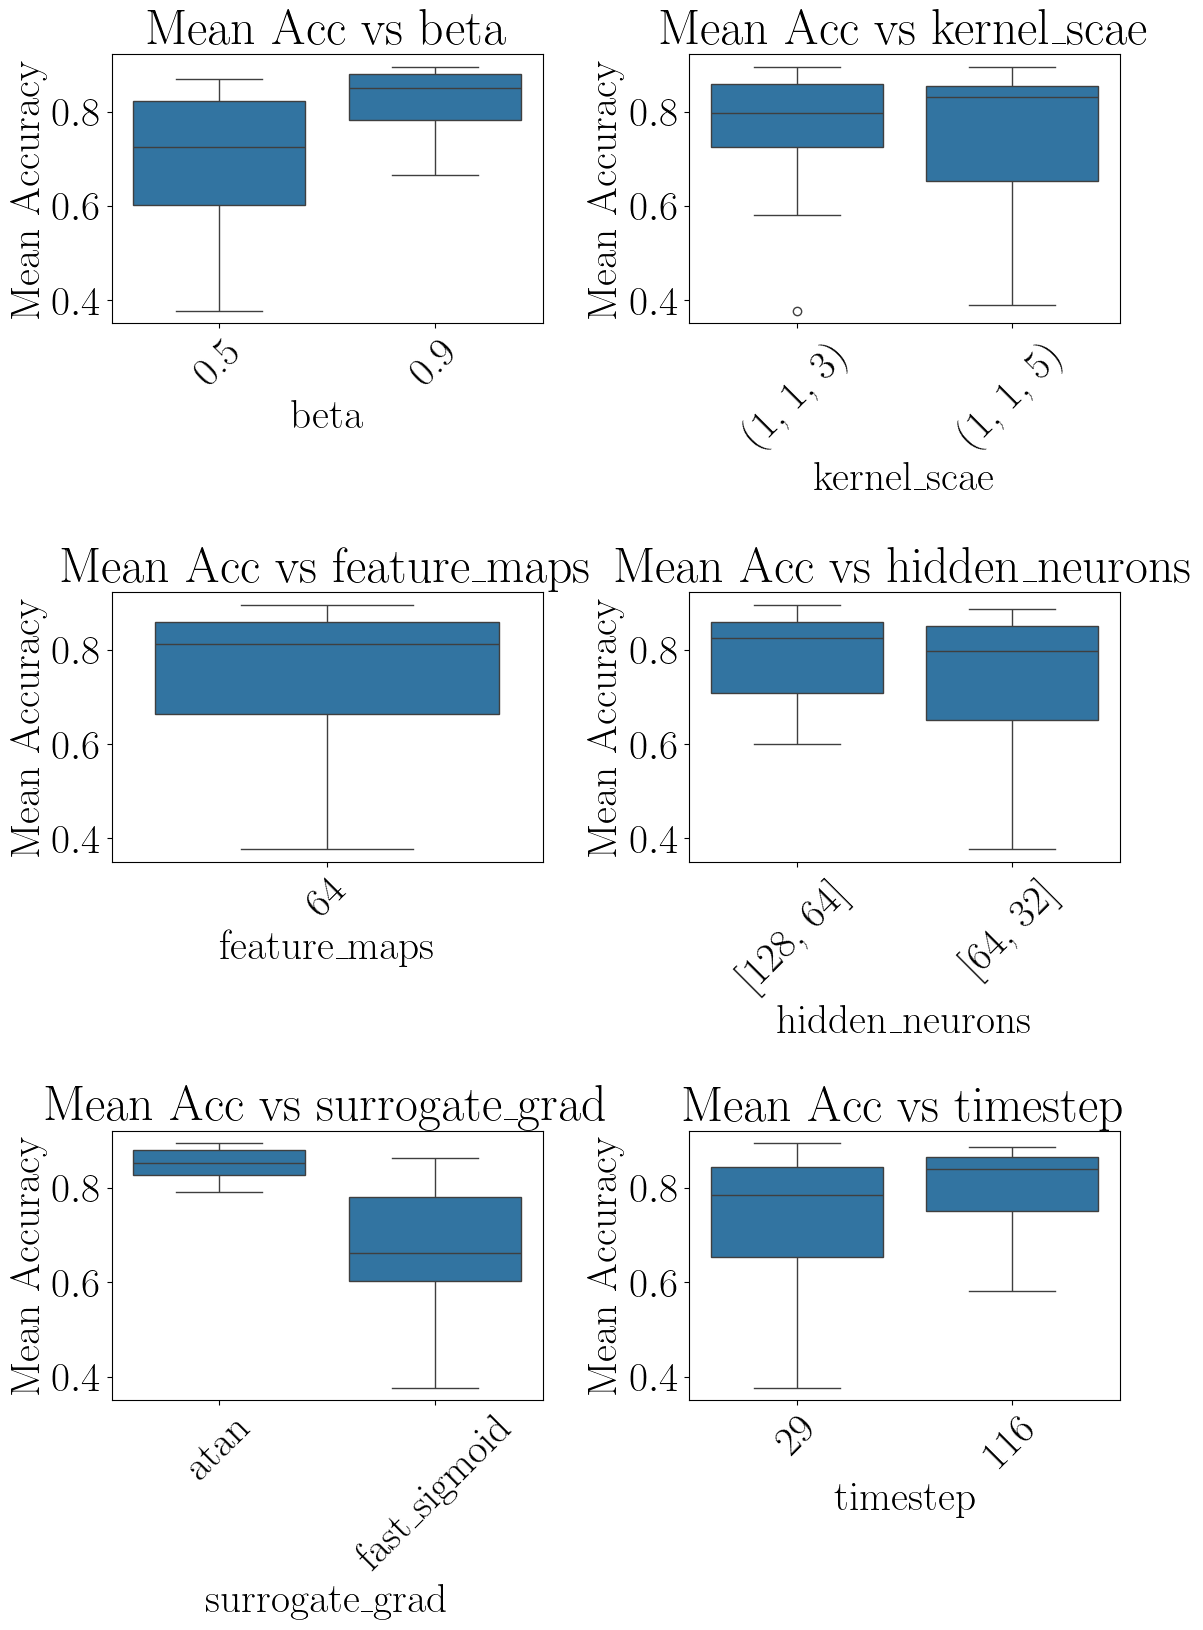

In [ ]:
# Columns to compare against mean_accuracy
cols = ['beta', 'kernel_scae', 'feature_maps', 'hidden_neurons', 'surrogate_grad', 'timestep']

fig, axes = plt.subplots(3, 2, figsize=(12, 17))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=col, y='mean_accuracy', data=results_df, ax=axes[i])
    axes[i].set_title(f'Mean Acc vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Mean Accuracy')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
surr_fn = surrogate.atan()

def objective(config):  
    assert torch.cuda.is_available()

    autoencoder = network.scae(
                           channels = config['feature_maps'], 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = config['threshold'], 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surr_fn,
                           )

    snn =  network.snn_1(input_shape = INP_SHAPE, 
                        hidden = config['hidden_neurons'], 
                        timesteps = config['timestep'],
                        kernel = (1,1,4),
                        stride = (1,2,2),
                        beta = 0.9, 
                        threshold = config['threshold'],
                        learn_thr = True, 
                        learn_beta = True,
                        surr_grad = surr_fn,
                        )
    
    net = SCAE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

    
    trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.85,
                Lambda = 0.0,
                acc_steps = 1,
                patience = 15,
                model_path = None)

    trainer.fit(
            train_loader = train_loader,
            val_loader = val_loader,
            epochs = 50)
        
    val_acc = np.mean(trainer.val_acc_ls)
    train.report({"mean_accuracy": val_acc})  

search_space = {"feature_maps": tune.grid_search([32, 64]),
                "hidden_neurons": tune.grid_search([[128,64], [64,128]]),
                "threshold": tune.grid_search([1.0, 0.8]),
                "timestep": tune.grid_search([8, 29, 116]),
                }

algo = BasicVariantGenerator() 

tuner = tune.Tuner( 
    tune.with_resources(
                        tune.with_parameters(objective),
                        resources={"cpu": 2, "gpu": 1}
                        ),
    tune_config = tune.TuneConfig(
                                metric = "mean_accuracy",
                                mode = "max",
                                search_alg = algo,
                                ),
    run_config = train.RunConfig(
                                name = "grid_search",
                                stop = {"training_iteration": 1, "mean_accuracy": 0.85},
                                ),
    param_space = search_space,
)
results = tuner.fit()
print("Best config is:", results.get_best_result().config)

(objective pid=19076) Epoch 1 - train_loss: 1.2604 | train_acc: 0.4756 | val_loss: 1.0738 | val_acc: 0.5069
(objective pid=19076) Epoch 6 - train_loss: 0.2872 | train_acc: 0.9107 | val_loss: 0.4200 | val_acc: 0.8125
(objective pid=19076) Epoch 11 - train_loss: 0.1992 | train_acc: 0.9476 | val_loss: 0.4086 | val_acc: 0.8472
(objective pid=19076) Epoch 16 - train_loss: 0.1521 | train_acc: 0.9673 | val_loss: 0.4355 | val_acc: 0.8403
(objective pid=19076) Epoch 21 - train_loss: 0.1157 | train_acc: 0.9821 | val_loss: 0.5907 | val_acc: 0.8194
(objective pid=19076) Early stopping at epoch 25
(objective pid=20853) Epoch 1 - train_loss: 1.1304 | train_acc: 0.5583 | val_loss: 0.7440 | val_acc: 0.7083
(objective pid=20853) Epoch 6 - train_loss: 0.4738 | train_acc: 0.8482 | val_loss: 0.7859 | val_acc: 0.6458
(objective pid=20853) Epoch 11 - train_loss: 0.2575 | train_acc: 0.9196 | val_loss: 0.4570 | val_acc: 0.8542
(objective pid=20853) Epoch 16 - train_loss: 0.1739 | train_acc: 0.9613 | val_loss:

2025-09-05 21:48:28,057	INFO tune.py:1007 -- Wrote the latest version of all result files and experiment state to '/home/eleonora/ray_results/grid_search' in 0.0068s.
2025-09-05 21:48:28,062	INFO tune.py:1039 -- Total run time: 40959.77 seconds (40959.73 seconds for the tuning loop).


Best config is: {'feature_maps': 64, 'hidden_neurons': [128, 64], 'threshold': 0.8, 'timestep': 116}


(objective pid=106129) Early stopping at epoch 44


In [6]:
results_df = results.get_dataframe()

# rename columns with params
results_df.rename(columns={'config/threshold': 'threshold', 
                           'config/feature_maps': 'feature_maps',
                           'config/hidden_neurons': 'hidden_neurons', 
                           'config/timestep': 'timestep'
                           },
                           inplace=True)

# keep just important columns
columns_to_keep = [ 'mean_accuracy',
                    'feature_maps',
                    'hidden_neurons',
                    'threshold',
                    'timestep'
                  ]

results_df = results_df[columns_to_keep]

results_df.to_csv('GridSearch_results_new_2.csv', index=False)


[autoreload of network failed: Traceback (most recent call last):
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/eleonora/.local/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
  File "/home/eleono

In [7]:
results_df = pd.read_csv('GridSearch_results_new_2.csv', header=0)
results_df.sort_values(by='mean_accuracy', axis=0, ascending=False).head(100)

,mean_accuracy,feature_maps,hidden_neurons,threshold,timestep
21,0.920782,64,"[128, 64]",0.8,116
18,0.916250,32,"[64, 128]",1.0,116
23,0.913272,64,"[64, 128]",0.8,116
13,0.908617,64,"[128, 64]",0.8,29
9,0.903391,64,"[128, 64]",1.0,29
14,0.902392,32,"[64, 128]",0.8,29
15,0.900042,64,"[64, 128]",0.8,29
17,0.895202,64,"[128, 64]",1.0,116
11,0.885417,64,"[64, 128]",1.0,29
22,0.882716,32,"[64, 128]",0.8,116


In [7]:
results_df = pd.read_csv('GridSearch_results_new_1.csv', header=0)
results_df.sort_values(by='mean_accuracy', axis=0, ascending=False).head(100)

,mean_accuracy,feature_maps,hidden_neurons,threshold,timestep
22,0.937500,32,"[64, 128]",0.8,116
19,0.923868,64,"[64, 128]",1.0,116
15,0.914722,64,"[64, 128]",0.8,29
20,0.904707,32,"[128, 64]",0.8,116
9,0.897263,64,"[128, 64]",1.0,29
6,0.896181,32,"[64, 128]",0.8,8
14,0.888056,32,"[64, 128]",0.8,29
13,0.887108,64,"[128, 64]",0.8,29
21,0.883247,64,"[128, 64]",0.8,116
11,0.877778,64,"[64, 128]",1.0,29


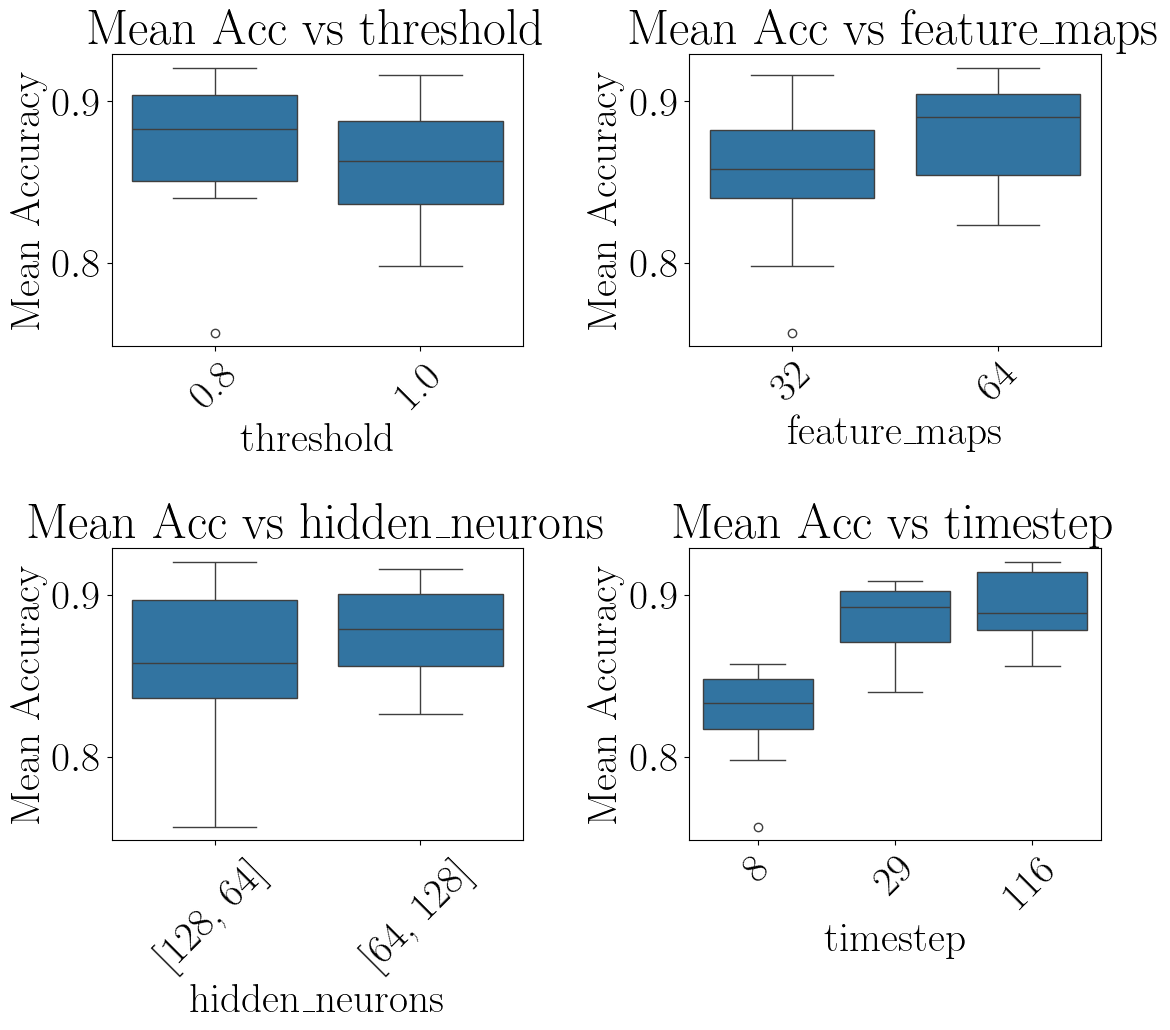

In [8]:
# Columns to compare against mean_accuracy
cols = ['threshold', 'feature_maps', 'hidden_neurons','timestep']

fig, axes = plt.subplots(2, 2, figsize=(12, 11))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=col, y='mean_accuracy', data=results_df, ax=axes[i])
    axes[i].set_title(f'Mean Acc vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Mean Accuracy')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

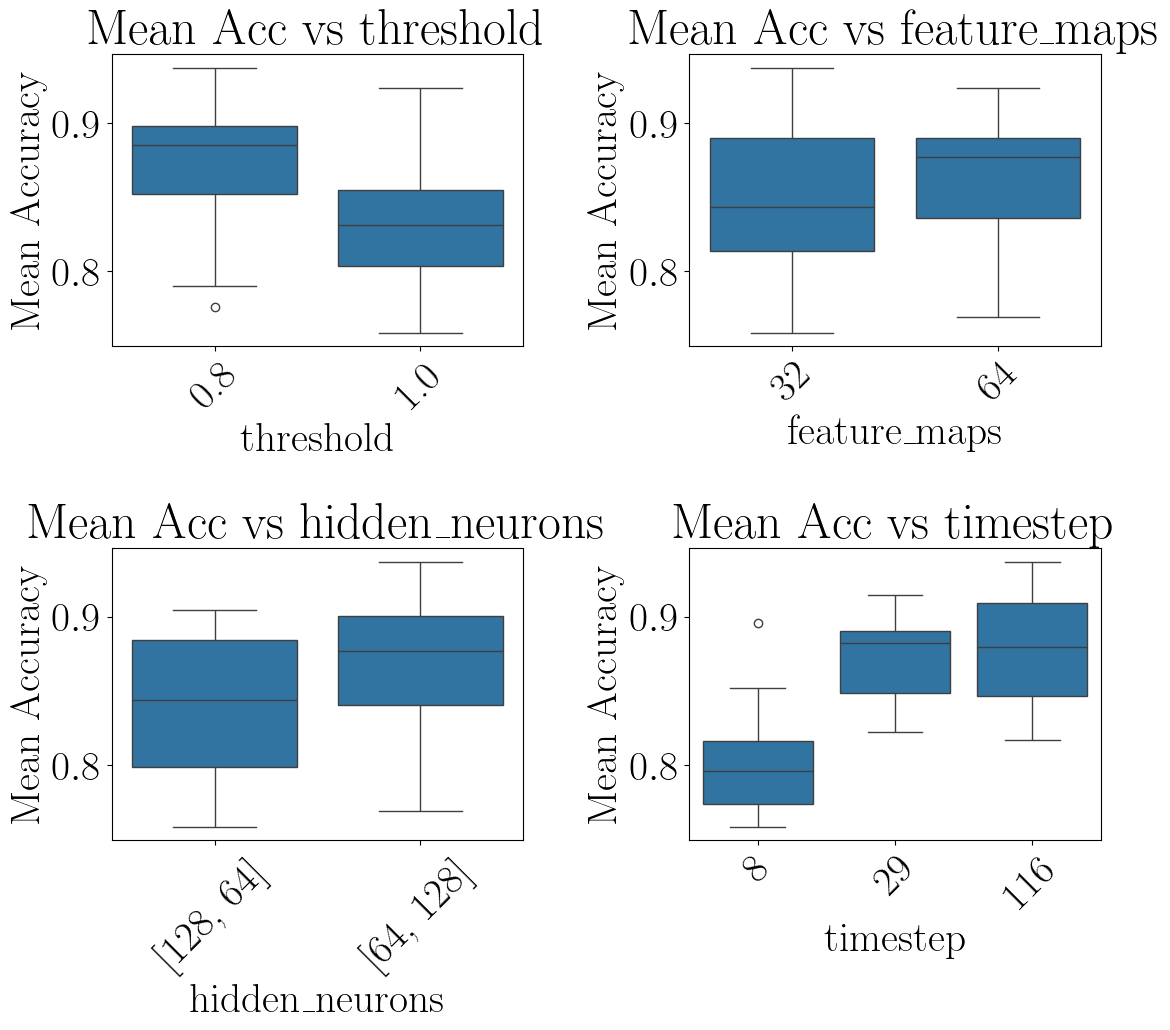

In [10]:
# Columns to compare against mean_accuracy
cols = ['threshold', 'feature_maps', 'hidden_neurons','timestep']

fig, axes = plt.subplots(2, 2, figsize=(12, 11))
axes = axes.flatten()

for i, col in enumerate(cols):
    sns.boxplot(x=col, y='mean_accuracy', data=results_df, ax=axes[i])
    axes[i].set_title(f'Mean Acc vs {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Mean Accuracy')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
surr_fn = surrogate.atan()
autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surr_fn
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = False, 
                     learn_beta = False,
                     surr_grad = surr_fn
                     )

net = SCAE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

res_dic = {}

for alpha in [0.5, 0.85, 0.95]:
    trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = alpha,
                Lambda = 0.4,
                acc_steps = 1,
                patience = 15,
                model_path = None 
    )

    trainer.fit(
        train_loader = train_loader,
        val_loader = val_loader,
        epochs = 50
    )

    res_dic[alpha] = trainer.val_acc_ls


Epoch 1 - train_loss: 0.5802 | train_acc: 0.6054 | val_loss: 0.4858 | val_acc: 0.6667
Epoch 2 - train_loss: 0.2690 | train_acc: 0.8631 | val_loss: 0.3005 | val_acc: 0.7569
Epoch 3 - train_loss: 0.2130 | train_acc: 0.9000 | val_loss: 0.2243 | val_acc: 0.9097
Epoch 4 - train_loss: 0.2114 | train_acc: 0.8964 | val_loss: 0.2238 | val_acc: 0.9028
Epoch 5 - train_loss: 0.1879 | train_acc: 0.9190 | val_loss: 0.3155 | val_acc: 0.8889
Epoch 6 - train_loss: 0.1825 | train_acc: 0.9280 | val_loss: 0.2358 | val_acc: 0.9236
Epoch 7 - train_loss: 0.1834 | train_acc: 0.9292 | val_loss: 0.2738 | val_acc: 0.9028
Epoch 8 - train_loss: 0.1655 | train_acc: 0.9411 | val_loss: 0.2340 | val_acc: 0.8819
Epoch 9 - train_loss: 0.1618 | train_acc: 0.9506 | val_loss: 0.2231 | val_acc: 0.9306
Epoch 10 - train_loss: 0.1564 | train_acc: 0.9506 | val_loss: 0.1969 | val_acc: 0.9375
Epoch 11 - train_loss: 0.1683 | train_acc: 0.9470 | val_loss: 0.2684 | val_acc: 0.8750
Epoch 12 - train_loss: 0.1575 | train_acc: 0.9536 | 

0.5
0.85
0.95


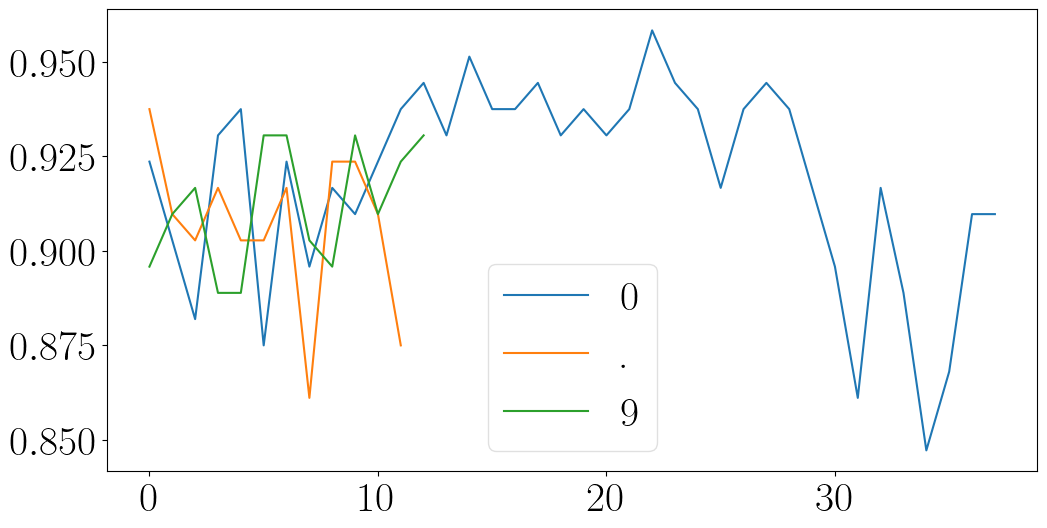

In [24]:
for a in [0.5, 0.85, 0.95]:
    plt.plot(res_dic[a][5:])
    plt.legend(str(a))

plt.show()

In [20]:
[np.mean(res_dic[a]) for a in [0.5, 0.85, 0.95]]

[0.9082687338501292, 0.9076797385620915, 0.9128086419753088]

In [25]:
surr_fn = surrogate.atan()

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surr_fn
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surr_fn
                     )

for lr in [1e-4, 1e-3]:
    net = SCAE(autoencoder, snn).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)


    trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = alpha,
                Lambda = 0.4,
                acc_steps = 1,
                patience = 15,
                model_path = None 
    )

    trainer.fit(
        train_loader = train_loader,
        val_loader = val_loader,
        epochs = 50
    )

    res_dic[lr] = trainer.val_acc_ls


Epoch 1 - train_loss: 0.1790 | train_acc: 0.6530 | val_loss: 0.1540 | val_acc: 0.7500
Epoch 2 - train_loss: 0.1348 | train_acc: 0.8637 | val_loss: 0.1325 | val_acc: 0.8681
Epoch 3 - train_loss: 0.1285 | train_acc: 0.8804 | val_loss: 0.1312 | val_acc: 0.8403
Epoch 4 - train_loss: 0.1255 | train_acc: 0.8952 | val_loss: 0.1288 | val_acc: 0.9097
Epoch 5 - train_loss: 0.1239 | train_acc: 0.9006 | val_loss: 0.1249 | val_acc: 0.8889
Epoch 6 - train_loss: 0.1213 | train_acc: 0.9155 | val_loss: 0.1262 | val_acc: 0.9306
Epoch 7 - train_loss: 0.1207 | train_acc: 0.9137 | val_loss: 0.1302 | val_acc: 0.8611
Epoch 8 - train_loss: 0.1196 | train_acc: 0.9286 | val_loss: 0.1220 | val_acc: 0.9236
Epoch 9 - train_loss: 0.1188 | train_acc: 0.9333 | val_loss: 0.1220 | val_acc: 0.9306
Epoch 10 - train_loss: 0.1179 | train_acc: 0.9357 | val_loss: 0.1227 | val_acc: 0.9375
Epoch 11 - train_loss: 0.1174 | train_acc: 0.9476 | val_loss: 0.1230 | val_acc: 0.9167
Epoch 12 - train_loss: 0.1160 | train_acc: 0.9488 | 

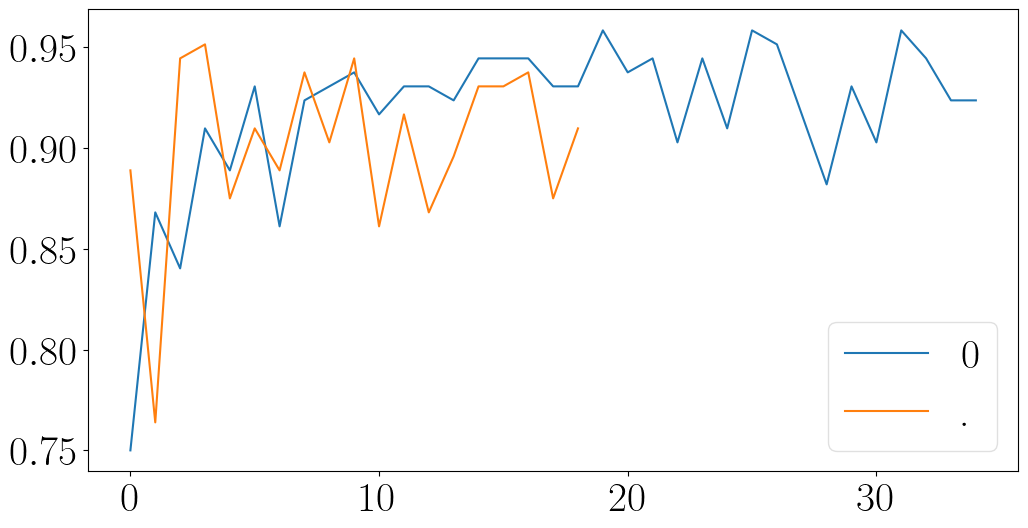

In [26]:
for lr in [1e-4, 1e-3]:
    plt.plot(res_dic[lr])
    plt.legend(str(lr))
plt.show()

## Sparsity regularization

In [ ]:
#df = pd.DataFrame(columns=["Lambda", "Sparsity_avg", "Sparsity_std", 
#                           "Accuracy_avg", "Accuracy_std"])

#df.to_csv("Sparsity_vs_accuracy_1.csv", index=False)

In [5]:
lambda_reg = np.arange(0.8, 1.1, 0.2)
surr_fn = surrogate.atan()

csv_path = "Sparsity_vs_accuracy_3.csv"

try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    df = pd.DataFrame(columns=["Lambda", 
                               "Sparsity_avg", "Sparsity_std", 
                               "Accuracy_avg", "Accuracy_std"])
    

for lambd in lambda_reg:
    print("###############")
    print(f"# Lambda = {lambd:.1f}")
    print("###############")
    sparsity_ls, accuracy_ls = [], []

    for run in range(5):
        print(f"  >> Run {run+1}/5")
        torch.cuda.empty_cache()

        autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = False, 
                           learn_threshold = False, 
                           surr_grad = surr_fn
                           )

        snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [128,64], 
                     timesteps = 116,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = False, 
                     learn_beta = False,
                     surr_grad = surr_fn
                     )

        net = SCAE(autoencoder, snn).to(device) 
        optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

        trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                Lambda = lambd,
                acc_steps = 1,
                patience = 15,
                model_path = None 
        )

        trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )

        _, accuracy, sparsity = trainer.evaluate(val_loader)

        sparsity_ls.append(sparsity)
        accuracy_ls.append(accuracy)

    new_row = pd.DataFrame([{"Lambda": lambd, 
                             "Sparsity_avg": np.mean(sparsity_ls), 
                             "Sparsity_std": np.std(sparsity_ls),
                             "Accuracy_avg": np.mean(accuracy_ls),
                             "Accuracy_std":np.std(accuracy_ls)}])
    df = pd.concat([df, new_row], ignore_index=True)
    df.to_csv(csv_path, index=False)


###############
# Lambda = 0.8
###############
  >> Run 1/5
Epoch 1 - train_loss: 1.3643 | train_acc: 0.4190 | val_loss: 1.2370 | val_acc: 0.5139
Epoch 6 - train_loss: 0.3971 | train_acc: 0.9113 | val_loss: 0.4853 | val_acc: 0.8819
Epoch 11 - train_loss: 0.3541 | train_acc: 0.9369 | val_loss: 0.5792 | val_acc: 0.8472
Epoch 16 - train_loss: 0.2895 | train_acc: 0.9589 | val_loss: 0.4860 | val_acc: 0.8611
Epoch 21 - train_loss: 0.2781 | train_acc: 0.9637 | val_loss: 0.4175 | val_acc: 0.9167
Epoch 26 - train_loss: 0.3094 | train_acc: 0.9690 | val_loss: 0.4548 | val_acc: 0.8958
Early stopping at epoch 28
  >> Run 2/5
Epoch 1 - train_loss: 1.1615 | train_acc: 0.5238 | val_loss: 1.0446 | val_acc: 0.4653
Epoch 6 - train_loss: 0.3498 | train_acc: 0.9518 | val_loss: 0.4844 | val_acc: 0.8819
Epoch 11 - train_loss: 0.3052 | train_acc: 0.9631 | val_loss: 0.4629 | val_acc: 0.9375
Epoch 16 - train_loss: 0.2847 | train_acc: 0.9685 | val_loss: 0.4108 | val_acc: 0.9375
Epoch 21 - train_loss: 0.2658 | tr

In [6]:
metrics = pd.read_csv('Sparsity_vs_accuracy_3.csv')
metrics

,Lambda,Sparsity_avg,Sparsity_std,Accuracy_avg,Accuracy_std
0,0.0,0.826045,0.017327,0.912500,0.024296
1,0.2,0.822695,0.022564,0.926389,0.025835
2,0.4,0.820943,0.015892,0.908333,0.027217
3,0.6,0.825405,0.015228,0.887500,0.036058
4,0.8,0.839449,0.010254,0.897222,0.053142
5,1.0,0.825158,0.010379,0.912500,0.035301


In [7]:
lambda_reg = metrics.Lambda.values
sparsity = metrics.Sparsity_avg	.values
avg_acc = metrics.Accuracy_avg.values

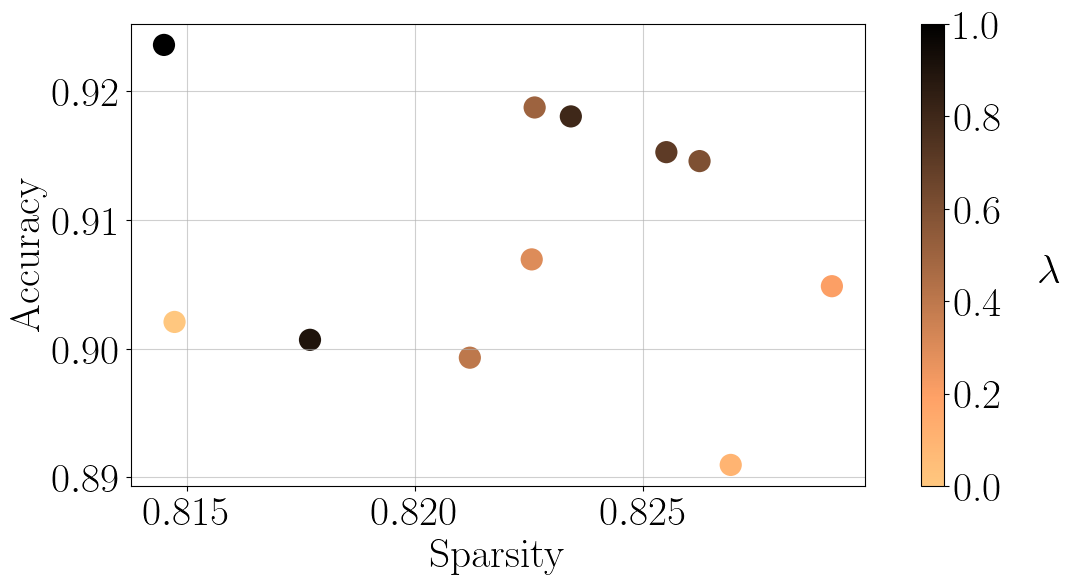

In [ ]:
plt.figure()
plt.scatter(sparsity, avg_acc, cmap=plt.colormaps.get_cmap('copper_r'),
            c=lambda_reg, linewidths=10)
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.grid()
colorbar = plt.colorbar(pad=0.06)#, location='top', orientation='horizontal')
colorbar.set_label(r'$\lambda$', labelpad=35, rotation=0)
colorbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#colorbar.set_ticks(lambda_reg)
colorbar.set_ticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.savefig("Plots/sparsity_vs_mse.pdf", bbox_inches='tight')
plt.show()

## Train with optimized hyperparams

In [20]:
autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surr_fn
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surr_fn
                     )

net = SCAE(autoencoder, snn).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)

trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                alpha = 0.95,
                Lambda = 1.0,
                acc_steps = 1,
                patience = 15,
                model_path = "./models/scae_snn_1.pt" 
        )

trainer.fit(
                train_loader = train_loader,
                val_loader = val_loader,
                epochs = 50
        )


Epoch 1 - train_loss: 0.7603 | train_acc: 0.7899 | val_loss: 0.4601 | val_acc: 0.9444
Epoch 6 - train_loss: 0.3536 | train_acc: 0.9524 | val_loss: 0.3707 | val_acc: 0.9583
Epoch 11 - train_loss: 0.2862 | train_acc: 0.9780 | val_loss: 0.4281 | val_acc: 0.9444
Epoch 16 - train_loss: 0.2992 | train_acc: 0.9792 | val_loss: 0.3575 | val_acc: 0.9375
Epoch 21 - train_loss: 0.2954 | train_acc: 0.9810 | val_loss: 0.5982 | val_acc: 0.8472
Early stopping at epoch 22


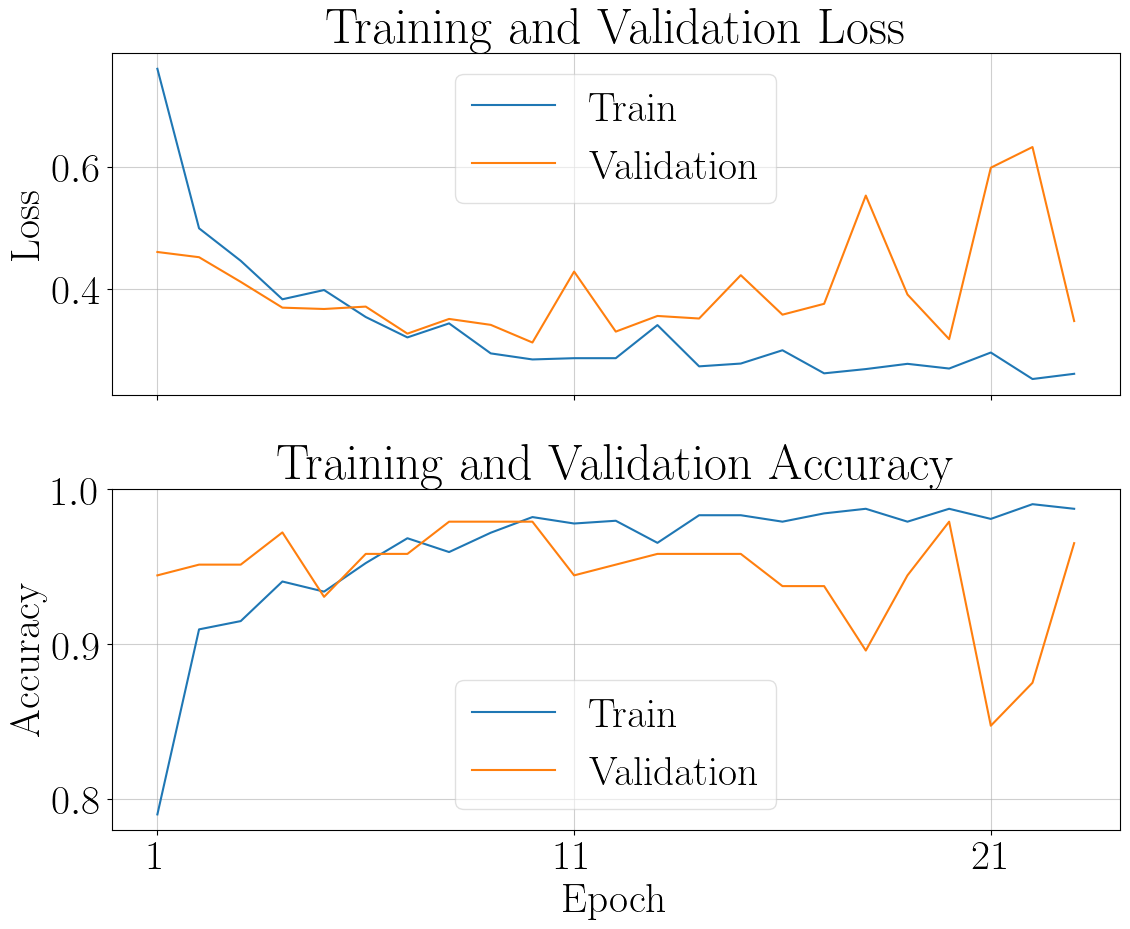

In [21]:
utils_fn.plot_curves(trainer.train_loss_ls, trainer.val_loss_ls, 
                     trainer.train_acc_ls, trainer.val_acc_ls)

# Results on test set

In [5]:
path = "./models/scae_snn_1.pt" 
checkpoint = torch.load(path, map_location=device)

autoencoder = network.scae(channels = 64, 
                           kernel_size = (1,1,3),
                           stride = 1, 
                           timesteps = 1,
                           beta = 0.9, 
                           threshold = 0.8, 
                           learn_beta = True, 
                           learn_threshold = True, 
                           surr_grad = surrogate.atan()
                           )

snn =  network.snn_1(input_shape = INP_SHAPE, 
                     hidden = [64,128], 
                     timesteps = 29,
                     kernel = (1,1,4),
                     stride = (1,2,2),
                     beta = 0.9,
                     threshold = 0.8,
                     learn_thr = True, 
                     learn_beta = True,
                     surr_grad = surrogate.atan()
                     )

net = SCAE(autoencoder, snn).to(device)
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()

SCAE(
  (autoencoder): scae(
    (enc_conv1): Conv3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif1): Leaky()
    (enc_conv2): Conv3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=same)
    (enc_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc_lif2): Leaky()
    (dec_conv1): ConvTranspose3d(2, 64, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dec_lif1): Leaky()
    (dec_conv2): ConvTranspose3d(64, 2, kernel_size=(1, 1, 3), stride=(1, 1, 1), padding=(0, 0, 1))
    (dec_bn2): BatchNorm3d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sigmoid): Sigmoid()
  )
  (snn): snn_1(
    (avg_pool): AvgPool3d(kernel_size=(1, 1, 4), stride=(1, 2, 2), padding=0)
    (fc_in): Linear(in_fea

In [27]:
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-3)
trainer = Trainer(
                model = net,
                optimizer = optimizer,
                device = device,
                model_path = "./models/scae_snn_1.pt" 
        )

acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="macro",  
                                verbose=True
                            )

AVERAGE TYPE: macro

Accuracy: 0.8956
Precision: 0.8917
Recall: 0.8754              
F1 score: 0.8609

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.99      0.96      0.97        79
     RUNNING       0.93      0.95      0.94        41
     SITTING       0.65      1.00      0.79        28
       HANDS       1.00      0.59      0.74        34

    accuracy                           0.90       182
   macro avg       0.89      0.88      0.86       182
weighted avg       0.92      0.90      0.89       182



In [24]:
acc, prec, rec, f1, confusion_mx = trainer.classification_metrics(
                                dataloader=test_loader,
                                avg_type="weighted",  
                                verbose=True
                            )

AVERAGE TYPE: weighted

Accuracy: 0.8754
Precision: 0.9246
Recall: 0.8956              
F1 score: 0.8944

Classification Report:
               precision    recall  f1-score   support

     WALKING       0.99      0.96      0.97        79
     RUNNING       0.93      0.95      0.94        41
     SITTING       0.65      1.00      0.79        28
       HANDS       1.00      0.59      0.74        34

    accuracy                           0.90       182
   macro avg       0.89      0.88      0.86       182
weighted avg       0.92      0.90      0.89       182



### Plot the confusion matrix

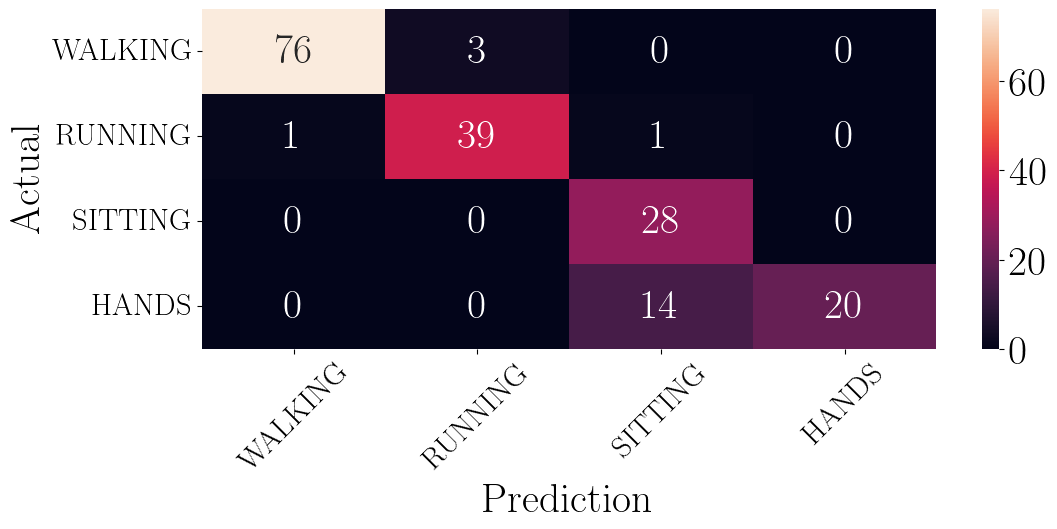

In [ ]:
sns.heatmap(confusion_mx,
            annot=True,
            fmt='g',
            xticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS'],
            yticklabels=['WALKING', 'RUNNING', 'SITTING', 'HANDS']
            )

plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.tick_params(axis='x', labelsize=22)  
plt.tick_params(axis='y', labelsize=22)  
plt.xticks(rotation=45)
plt.tight_layout() 
#plt.savefig("Plots/Conf_matrix/conf_mx_scae_snn_1.png", bbox_inches='tight')
plt.show()